In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf
import shap
from matplotlib import colors
import random


/home/mcoughlan/anaconda3/envs/env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mcoughlan/anaconda3/envs/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/prepared_data/SW_only_OTT_train_dict.pkl', 'rb') as f:
	sw_train_dict = pickle.load(f)

with open('../data/prepared_data/SW_only_OTT_test_dict.pkl', 'rb') as d:
	sw_test_dict = pickle.load(d)

with open('../data/prepared_data/combined_OTT_train_dict.pkl', 'rb') as c:
	combined_train_dict = pickle.load(c)

with open('../data/prepared_data/combined_OTT_test_dict.pkl', 'rb') as b:
	combined_test_dict = pickle.load(b)

sw_model = load_model('models/OTT/CNN_SW_only_split_50.h5')
combined_model = load_model('models/OTT/CNN_version_5_split_50.h5')

2023-03-15 11:42:34.408064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 11:42:34.408899: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
combined_results, sw_results = pd.DataFrame(), pd.DataFrame()

for key in combined_test_dict.keys():

	sw = pd.read_feather(f'outputs/OTT/SW_only_{key}.feather')
	comb = pd.read_feather(f'outputs/OTT/version_5_{key}.feather')

	sw_results = pd.concat([sw_results, sw], axis=0, ignore_index=True).reset_index(drop=True)
	combined_results = pd.concat([combined_results, comb], axis=0, ignore_index=True).reset_index(drop=True)

In [4]:
print(sw_train_dict['X'].shape)
print(sw_test_dict['storm_0']['Y'].shape)
print(combined_train_dict['X'].shape)
print(combined_test_dict['storm_0']['Y'].shape)

(834961, 30, 10)
(5792, 30, 10)
(834953, 30, 16)
(5792, 30, 16)


In [5]:
# # reducing the amount of the training dataset used to find the shap values
# combined_xtrain = combined_train_dict['X']
# combined_xtrain = combined_xtrain.reshape((combined_xtrain.shape[0], combined_xtrain.shape[1], combined_xtrain.shape[2], 1))
# combined_background = combined_xtrain[np.random.choice(combined_xtrain.shape[0], 1000, replace=False)]

# # attempting to use shap
# combined_explainer = shap.DeepExplainer(combined_model, combined_background)

# sw_xtrain = sw_train_dict['X']
# sw_xtrain = sw_xtrain.reshape((sw_xtrain.shape[0], sw_xtrain.shape[1], sw_xtrain.shape[2], 1))
# sw_background = sw_xtrain[np.random.choice(sw_xtrain.shape[0], 1000, replace=False)]

# # attempting to use shap
# sw_explainer = shap.DeepExplainer(sw_model, sw_background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [6]:
combined, solar, combined_unscaled, solar_unscaled, combined_crossing, sw_crossing = [], [], [], [], [], []
combined_real, sw_real = pd.DataFrame(), pd.DataFrame()

for comb, sw in zip(combined_test_dict.keys(), sw_test_dict.keys()):
	combined.append(combined_test_dict[comb]['Y'])
	solar.append(sw_test_dict[sw]['Y'])
	combined_unscaled.append(combined_test_dict[comb]['unscaled_array'])
	solar_unscaled.append(sw_test_dict[sw]['unscaled_array'])
	combined_real = pd.concat([combined_real, combined_test_dict[comb]['real_df']], axis=0, ignore_index=True).reset_index(drop=True)
	sw_real = pd.concat([sw_real, sw_test_dict[sw]['real_df']], axis=0, ignore_index=True).reset_index(drop=True)

for i in range(len(combined_real)):
	if combined_real['crossing'][i] == 1:
		combined_crossing.append(np.ones(30))
		sw_crossing.append(np.ones(30))
	elif combined_real['crossing'][i] == 0:
		combined_crossing.append(np.zeros(30))
		sw_crossing.append(np.zeros(30))
	else:
		a = np.empty((30))
		a[:] = np.nan
		combined_crossing.append(a)
		sw_crossing.append(a)

combined_xtest = np.concatenate(combined, axis=0)
solarwind_xtest = np.concatenate(solar, axis=0)
combined_unscaled = np.concatenate(combined_unscaled, axis=0)
sw_unscaled = np.concatenate(solar_unscaled, axis=0)
combined_crossing = np.concatenate(combined_crossing, axis=0)
sw_crossing = np.concatenate(sw_crossing, axis=0)


combined_xtest = combined_xtest.reshape((combined_xtest.shape[0], combined_xtest.shape[1], combined_xtest.shape[2], 1))
solarwind_xtest = solarwind_xtest.reshape((solarwind_xtest.shape[0], solarwind_xtest.shape[1], solarwind_xtest.shape[2], 1))


In [7]:
# combined_shap_values_check = combined_explainer.shap_values(combined_xtest, check_additivity=True)
# print('Finished Combined Shap values. Onto solar wind ones....')
# sw_shap_values_check = sw_explainer.shap_values(solarwind_xtest, check_additivity=True)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


KeyboardInterrupt: 

In [94]:
sw_features = ["sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   		"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T"]
combined_features = ["N", "E", "sinMLT", "cosMLT", "B_Total", "BY_GSM",
	   					"BZ_GSM", "Vx", "Vy", "Vz", "proton_density", "T",
	   					 "AE_INDEX", "SZA", "dBHt", "B"]

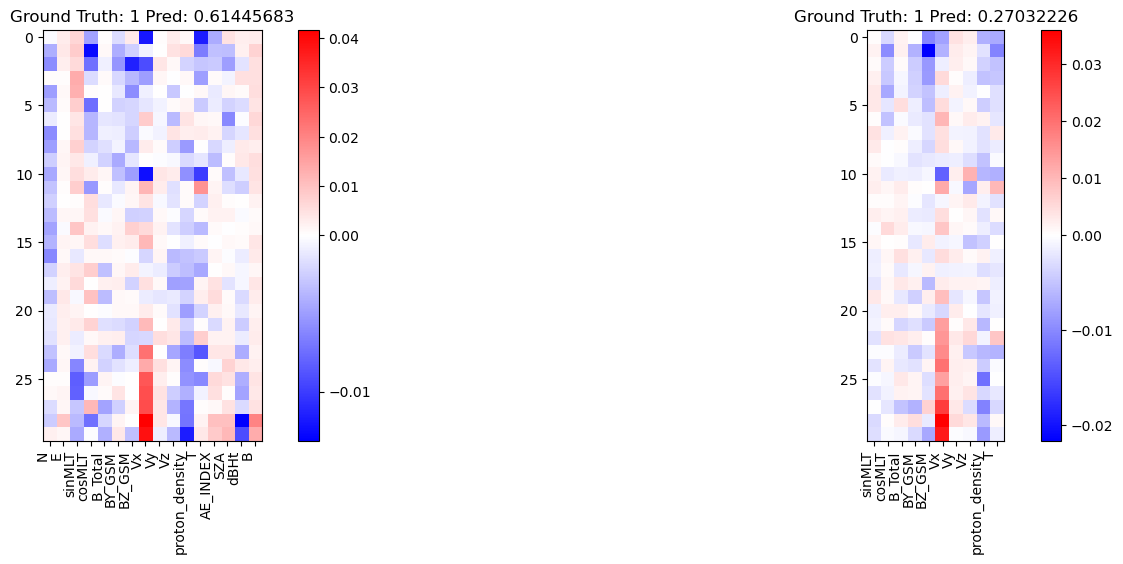

In [223]:
len_xtest = len(combined_xtest)
step = random.randint(0,len_xtest)

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(221)

plt.title('Ground Truth: '+str(combined_real['crossing'][step])+' Pred: '+str(combined_results['predicted_split_50'][step]))
divnorm=colors.TwoSlopeNorm(vcenter=0)
plt.imshow(combined_shap_values[1][step], cmap='bwr', norm=divnorm)
plt.colorbar()
x = [i for i in range(combined_shap_values[1].shape[2])]
ax.set_xticks(x)
ax.set_xticklabels(combined_features, rotation=90, ha='right')

ax = plt.subplot(222)
plt.title('Ground Truth: '+str(sw_real['crossing'][step])+' Pred: '+str(sw_results['predicted_split_50'][step]))
divnorm=colors.TwoSlopeNorm(vcenter=0)
plt.imshow(sw_shap_values[1][step], cmap='bwr', norm=divnorm)
plt.colorbar()
x = [i for i in range(sw_shap_values[1].shape[2])]
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90, ha='right')

plt.tight_layout()
plt.show()

In [201]:
def creating_plotting_df(shap_array, Xtest, param, param_loc):

	plotting_df = pd.DataFrame()

	shap_array = shap_array[:,:,:,0]

	nums = [30-i for i in range(30)]
	i = 0
	for arr, test in zip(shap_array, Xtest):
		df = pd.DataFrame({'shap_values':arr[:, param_loc],
							param: test[:, param_loc],
							'time_hist':nums})

		plotting_df = pd.concat([plotting_df, df], axis=0, ignore_index=True).reset_index(drop=True)
		i+=1
	plotting_df.dropna(inplace=True)
	return plotting_df

In [426]:
feat = 'BZ_GSM'

combined_plotting_df = creating_plotting_df(combined_shap_values[1], combined_unscaled, feat, combined_features.index(feat))
sw_plotting_df = creating_plotting_df(sw_shap_values[1], sw_unscaled, feat, sw_features.index(feat))

(1134480, 3)
(1107054, 3)
(1134480, 3)
(1107054, 3)


In [427]:
combined_plotting_df = combined_plotting_df[combined_plotting_df['shap_values']<=1]
combined_plotting_df = combined_plotting_df[combined_plotting_df['shap_values']>=-1]

sw_plotting_df = sw_plotting_df[sw_plotting_df['shap_values']<=1]
sw_plotting_df = sw_plotting_df[sw_plotting_df['shap_values']>=-1]

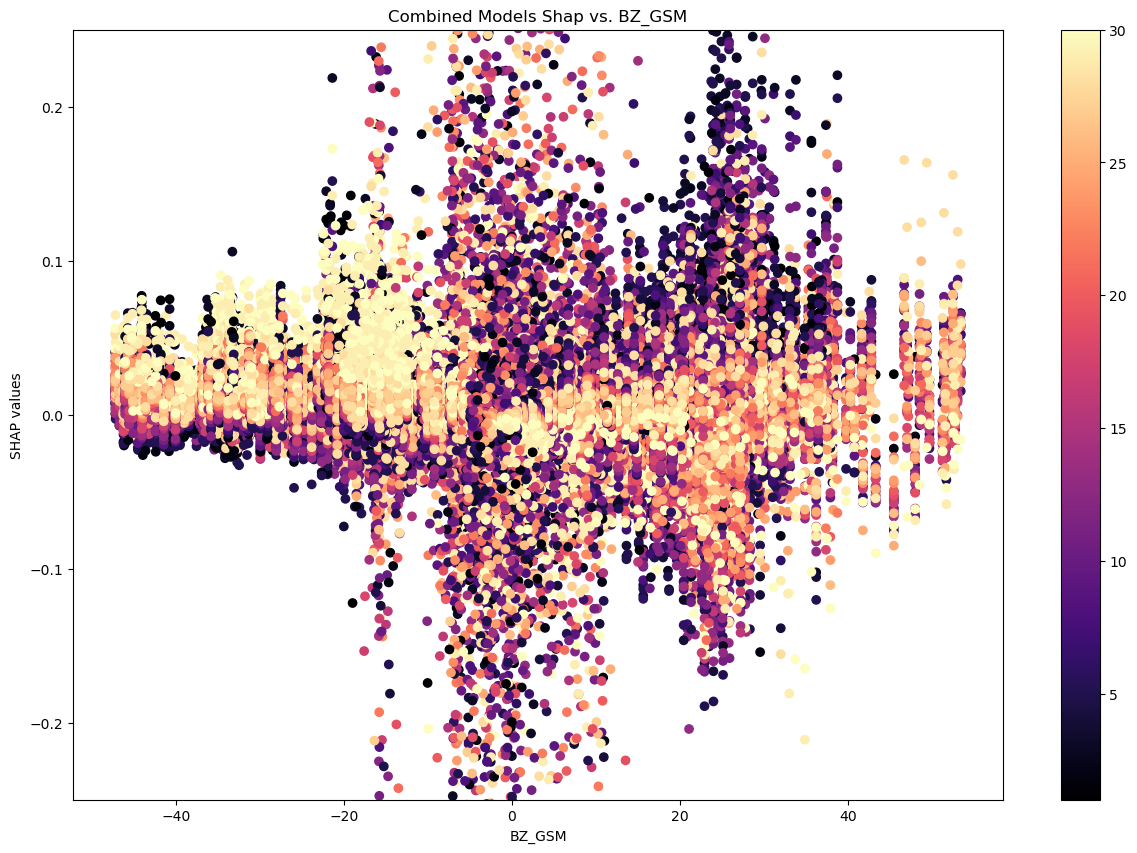

In [428]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

plt.title(f'Combined Models Shap vs. {feat}')
plt.scatter(x=combined_plotting_df[feat], y=combined_plotting_df['shap_values'], c=combined_plotting_df['time_hist'], cmap='magma')
plt.colorbar()
plt.ylim(-0.25,0.25)
plt.xlabel(feat)
plt.ylabel('SHAP values')
plt.show()

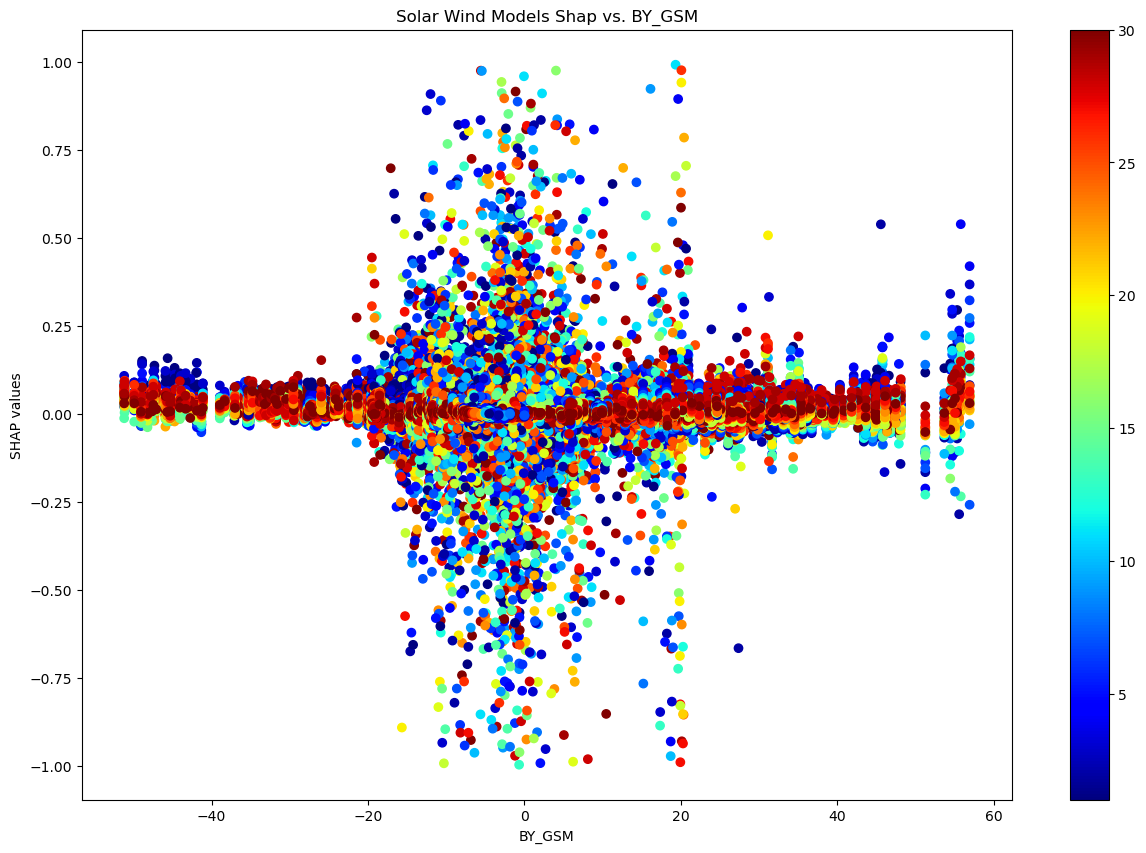

In [417]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

plt.title(f'Solar Wind Models Shap vs. {feat}')
plt.scatter(x=sw_plotting_df[feat], y=sw_plotting_df['shap_values'], c=sw_plotting_df['time_hist'], cmap='jet')
plt.colorbar()
plt.xlabel(feat)
plt.ylabel('SHAP values')
plt.show()

In [322]:
def creating_plotting_df_with_param_splits(shap_array, Xtest, param, param_loc, split_param, split_param_loc, split_param_values, crossing):

	plotting_df = pd.DataFrame()

	shap_array = shap_array[:,:,:,0]

	nums = [30-i for i in range(30)]
	
	for arr, test in zip(shap_array, Xtest):
		
		df = pd.DataFrame({'shap_values':arr[:, param_loc],
							param: test[:, param_loc],
							'time_hist':nums,
							split_param: test[:, split_param_loc]})

		plotting_df = pd.concat([plotting_df, df], axis=0, ignore_index=True).reset_index(drop=True)

	plotting_df['crossing'] = crossing
	crossing_dfs, no_crossing_dfs = [], []
	crossing_df = plotting_df[plotting_df['crossing']==1]
	no_crossing_df = plotting_df[plotting_df['crossing']==0]
	for i in range(len(split_param_values)):
		if i == 0:
			df = crossing_df[crossing_df[split_param]<=split_param_values[i]]
			df = df[df['shap_values'].abs()<=1]
			df.dropna(inplace=True)
			crossing_dfs.append(df)

			df = no_crossing_df[no_crossing_df[split_param]<=split_param_values[i]]
			df = df[df['shap_values'].abs()<=1]
			df.dropna(inplace=True)
			no_crossing_dfs.append(df)
		
		if (i <= (len(split_param_values)-1)) and (i != 0):
			df = crossing_df[crossing_df[split_param]>split_param_values[i-1]]
			df = df[df[split_param]<=split_param_values[i]]
			df = df[df['shap_values'].abs()<=1]
			df.dropna(inplace=True)
			crossing_dfs.append(df)

			df = no_crossing_df[no_crossing_df[split_param]>split_param_values[i-1]]
			df = df[df[split_param]<=split_param_values[i]]
			df = df[df['shap_values'].abs()<=1]
			df.dropna(inplace=True)
			no_crossing_dfs.append(df)

		if i == (len(split_param_values)-1):
			df = crossing_df[crossing_df[split_param]>split_param_values[i]]
			df = df[df['shap_values'].abs()<=1]
			df.dropna(inplace=True)
			crossing_dfs.append(df)

			df = no_crossing_df[no_crossing_df[split_param]>split_param_values[i]]
			df = df[df['shap_values'].abs()<=1]
			df.dropna(inplace=True)
			no_crossing_dfs.append(df)
	
	return crossing_dfs, no_crossing_dfs

In [429]:
splitting_feat = 'Vx'
splitting_feat_values = [500, 700, 850]
crossing_combined_plotting_split_df, no_crossing_combined_plotting_split_df = creating_plotting_df_with_param_splits(combined_shap_values[1], combined_unscaled, feat, combined_features.index(feat), \
																		splitting_feat, combined_features.index(splitting_feat), splitting_feat_values, combined_crossing)
crossing_sw_plotting_split_df, no_crossing_sw_plotting_split_df = creating_plotting_df_with_param_splits(sw_shap_values[1], sw_unscaled, feat, sw_features.index(feat), \
																		splitting_feat, sw_features.index(splitting_feat), splitting_feat_values, sw_crossing)

In [435]:
def density_plotting(crossing_df, no_crossing_df, feat, bin_nums, shap_lim, title, splitting_feat, splitting_feat_values):

	for i, (yes, no) in enumerate(zip(crossing_df, no_crossing_df)):

		yes = yes[yes['shap_values'].abs()<=shap_lim]
		no = no[no['shap_values'].abs()<=shap_lim]

		fig = plt.figure(figsize=(15,10))
		ax = plt.subplot(221)
		if i == 0:
			plt.title(f'Crossing {title} Models Shap vs. {feat} for {splitting_feat} < {splitting_feat_values[i]}')
		if (i < (len(crossing_df)-1)) and (i != 0):
			plt.title(f'Crossing {title} Models Shap vs. {feat} for {splitting_feat} = {splitting_feat_values[i-1]}-{splitting_feat_values[i]}')
		if i == len(crossing_df)-1:
			plt.title(f'Crossing {title} Models Shap vs. {feat} for {splitting_feat} > {splitting_feat_values[i-1]}')
		# plt.scatter(x=yes[feat], y=yes['shap_values'], c=yes['time_hist'], cmap='jet')
		x_array = [(yes[feat].min()*j/bin_nums) for j in range(bin_nums,0,-1)] + [(yes[feat].max()*k/bin_nums) for k in range(0,bin_nums+1)]
		y_array = [(yes['shap_values'].min()*j/bin_nums) for j in range(bin_nums,0,-1)] + [(yes['shap_values'].max()*k/bin_nums) for k in range(0,bin_nums+1)]
		plt.hist2d(x=yes[feat], y=yes['shap_values'], bins=[x_array,y_array], norm=colors.LogNorm())
		plt.colorbar()
		plt.axhline(0, linestyle='--', color='black')
		plt.axvline(0, linestyle='--', color='black')
		plt.xlabel(feat)
		plt.ylabel('SHAP values')

		ax = plt.subplot(222)
		if i == 0:
			plt.title(f'No Crossing {title} Models Shap vs. {feat} for {splitting_feat} < {splitting_feat_values[i]}')
		if (i < (len(no_crossing_df)-1)) and (i != 0):
			plt.title(f'No Crossing {title} Models Shap vs. {feat} for {splitting_feat} = {splitting_feat_values[i-1]}-{splitting_feat_values[i]}')
		if i == len(no_crossing_df)-1:
			plt.title(f'No Crossing {title} Models Shap vs. {feat} for {splitting_feat} > {splitting_feat_values[i-1]}')
		# plt.scatter(x=no[feat], y=no['shap_values'], c=no['time_hist'], cmap='jet')
		if no[feat].min() >= 0:
			x_array = [(no[feat].max()*k/(bin_nums*2)) for k in range(0,(bin_nums*2)+1)]
		else:
			x_array = [(no[feat].min()*j/bin_nums) for j in range(bin_nums,0,-1)] + [(no[feat].max()*k/bin_nums) for k in range(0,bin_nums+1)]
		if no['shap_values'].min() >= 0:
			y_array = [(no['shap_values'].max()*k/(bin_nums*2)) for k in range(0,(bin_nums*2)+1)]
		else:
			y_array = [(no['shap_values'].min()*j/bin_nums) for j in range(bin_nums,0,-1)] + [(no['shap_values'].max()*k/bin_nums) for k in range(0,bin_nums+1)]

		plt.hist2d(x=no[feat], y=no['shap_values'], bins=[x_array,y_array], norm=colors.LogNorm())
		plt.colorbar()
		plt.axhline(0, linestyle='--', color='black')
		plt.axvline(0, linestyle='--', color='black')
		plt.xlabel(feat)
		plt.ylabel('SHAP values')
		plt.show()

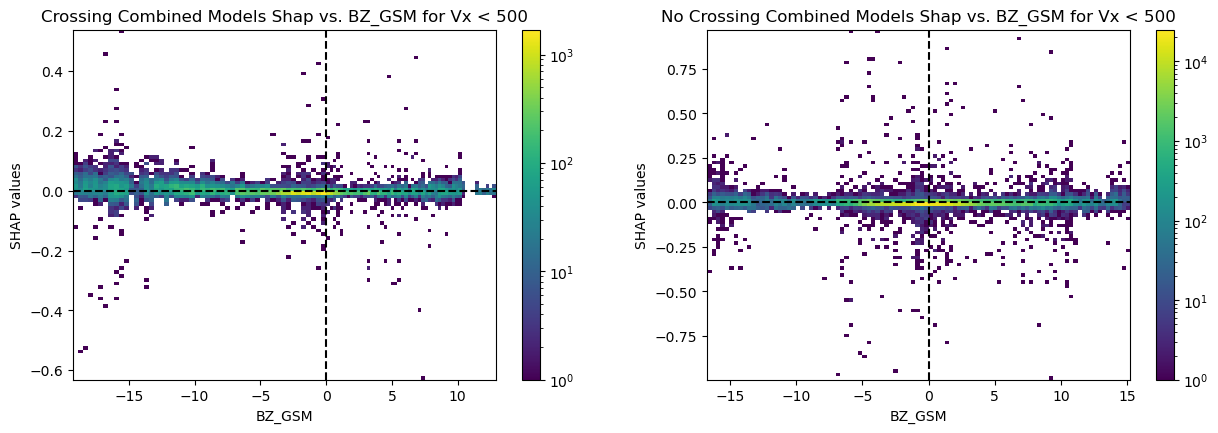

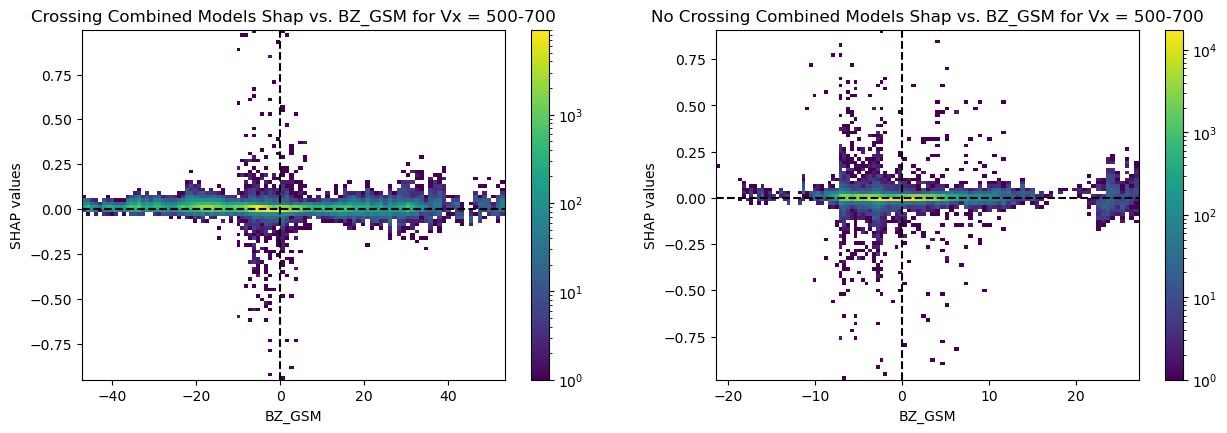

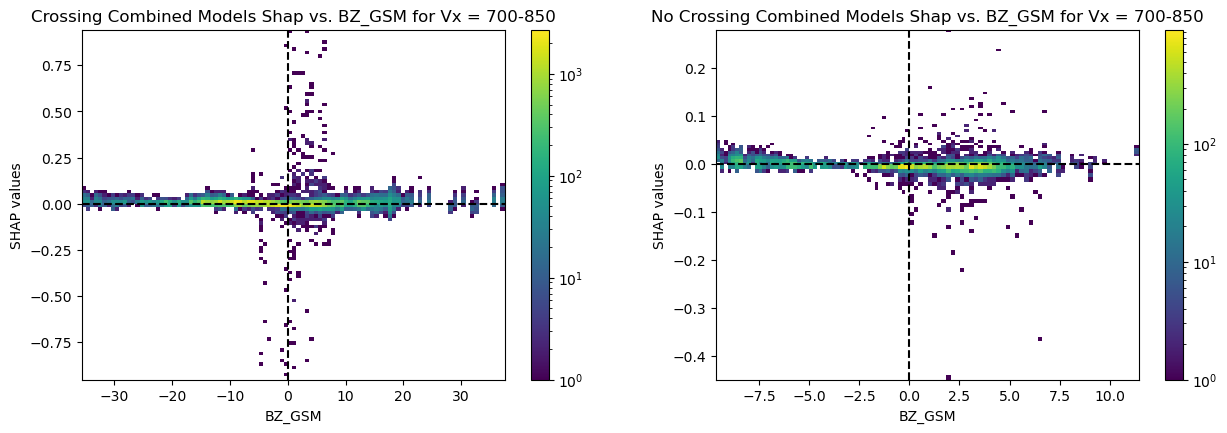

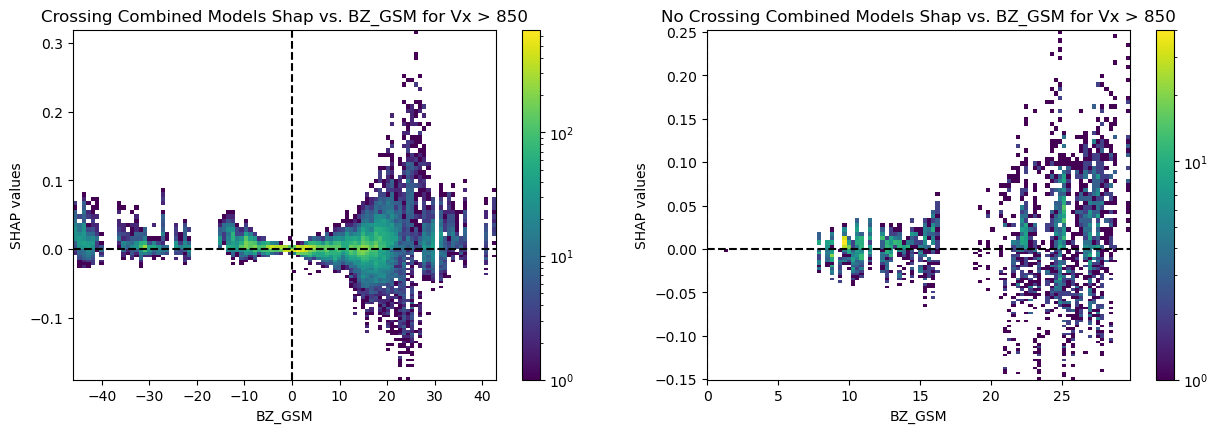

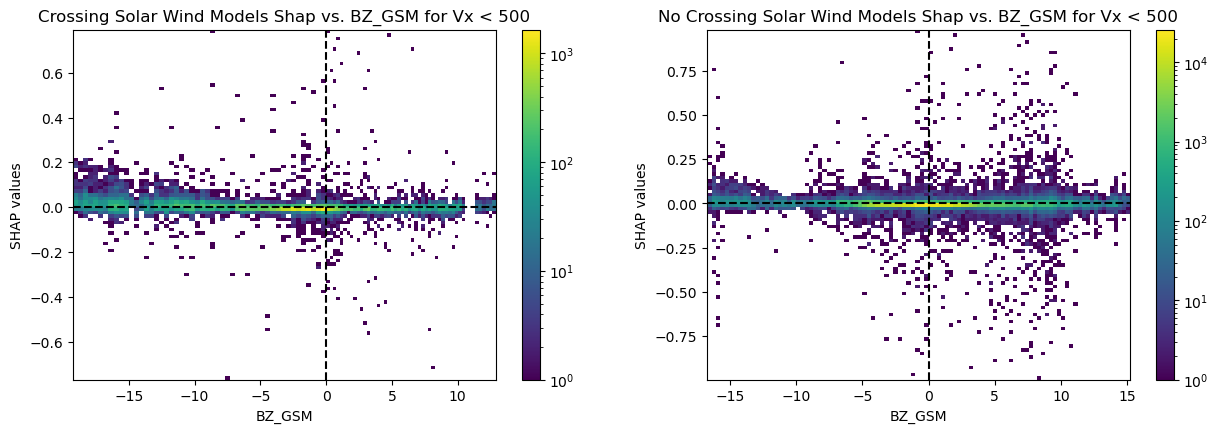

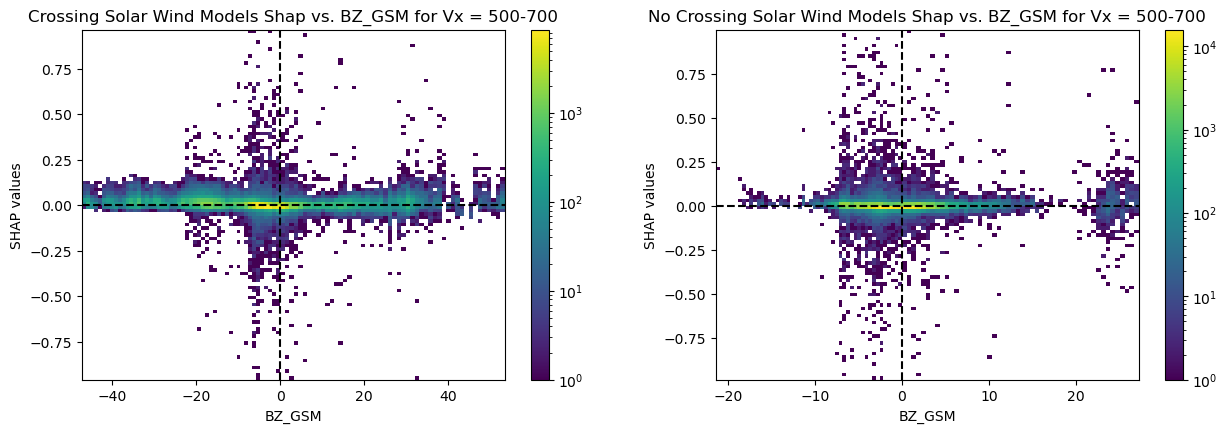

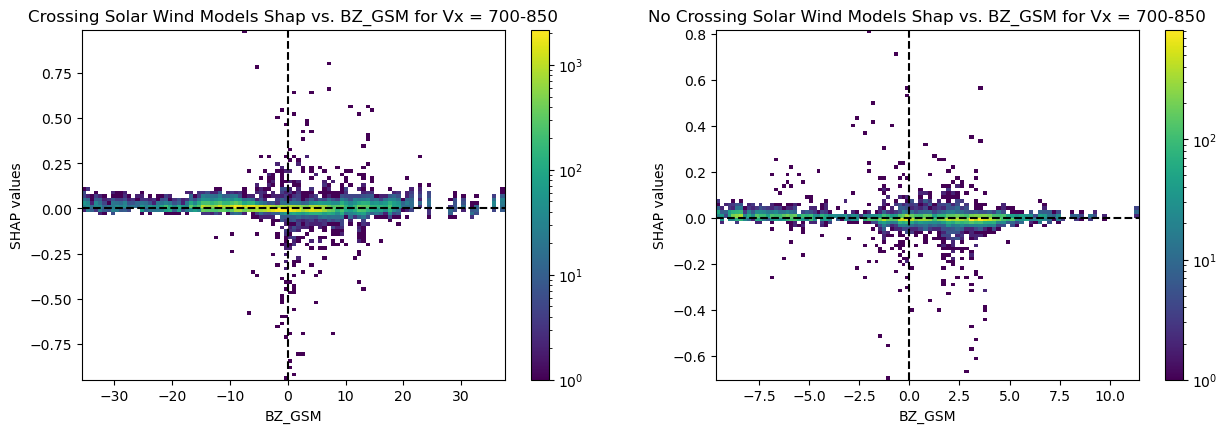

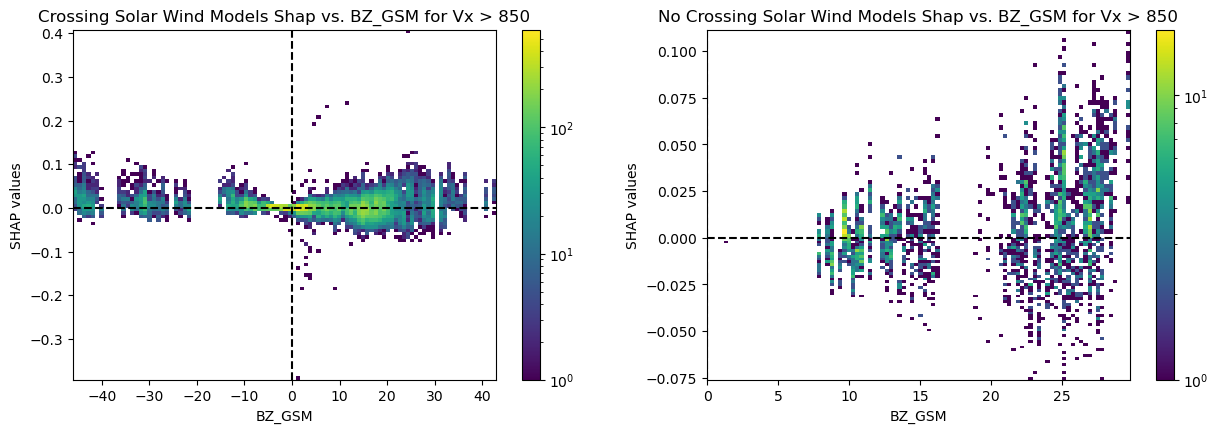

In [456]:
feat = 'BZ_GSM'
bin_nums = 50
shap_lim = 1
splitting_feat = 'Vx'
splitting_feat_values = [500, 700, 850]

density_plotting(crossing_combined_plotting_split_df, no_crossing_combined_plotting_split_df, feat=feat, \
					bin_nums=bin_nums, shap_lim=shap_lim, title='Combined', splitting_feat=splitting_feat, \
					splitting_feat_values=splitting_feat_values)

density_plotting(crossing_sw_plotting_split_df, no_crossing_sw_plotting_split_df, feat=feat, \
					bin_nums=bin_nums, shap_lim=shap_lim, title='Solar Wind', splitting_feat=splitting_feat,\
					splitting_feat_values=splitting_feat_values)

In [482]:
def taking_the_binned_sum(dfs, feat, bin_nums):

	dataframes = []

	for df in dfs:
		
		dataframe = pd.DataFrame()
		if df[feat].min() > 0:
			x_array = [(df[feat].max()*k/(bin_nums*2)) for k in range(0,(bin_nums*2)+1)]
		else:
			x_array = [(df[feat].min()*j/bin_nums) for j in range(bin_nums,0,-1)] + [(df[feat].max()*k/bin_nums) for k in range(0,bin_nums+1)]

		sums = []
		for i in range(len(x_array)-1):
			temp = df[(df[feat]>=x_array[i]) & (df[feat]<x_array[i+1])]
			sums.append(temp['shap_values'].mean())
		dataframe['arrays'] = x_array[:-1]
		dataframe['sums'] = sums
		dataframe.set_index('arrays', drop=True, inplace=True)	
		
		dataframes.append(dataframe)
	
	return dataframes

In [485]:
feature = 'BZ_GSM'
num_bins = 500

combined_crossing_sums = taking_the_binned_sum(crossing_combined_plotting_split_df, feature, num_bins)
combined_no_crossing_sums = taking_the_binned_sum(no_crossing_combined_plotting_split_df, feature, num_bins)
sw_crossing_sums = taking_the_binned_sum(crossing_sw_plotting_split_df, feature, num_bins)
sw_no_crossing_sums = taking_the_binned_sum(no_crossing_sw_plotting_split_df, feature, num_bins)

all_sums = [combined_crossing_sums, combined_no_crossing_sums, sw_crossing_sums, sw_no_crossing_sums]

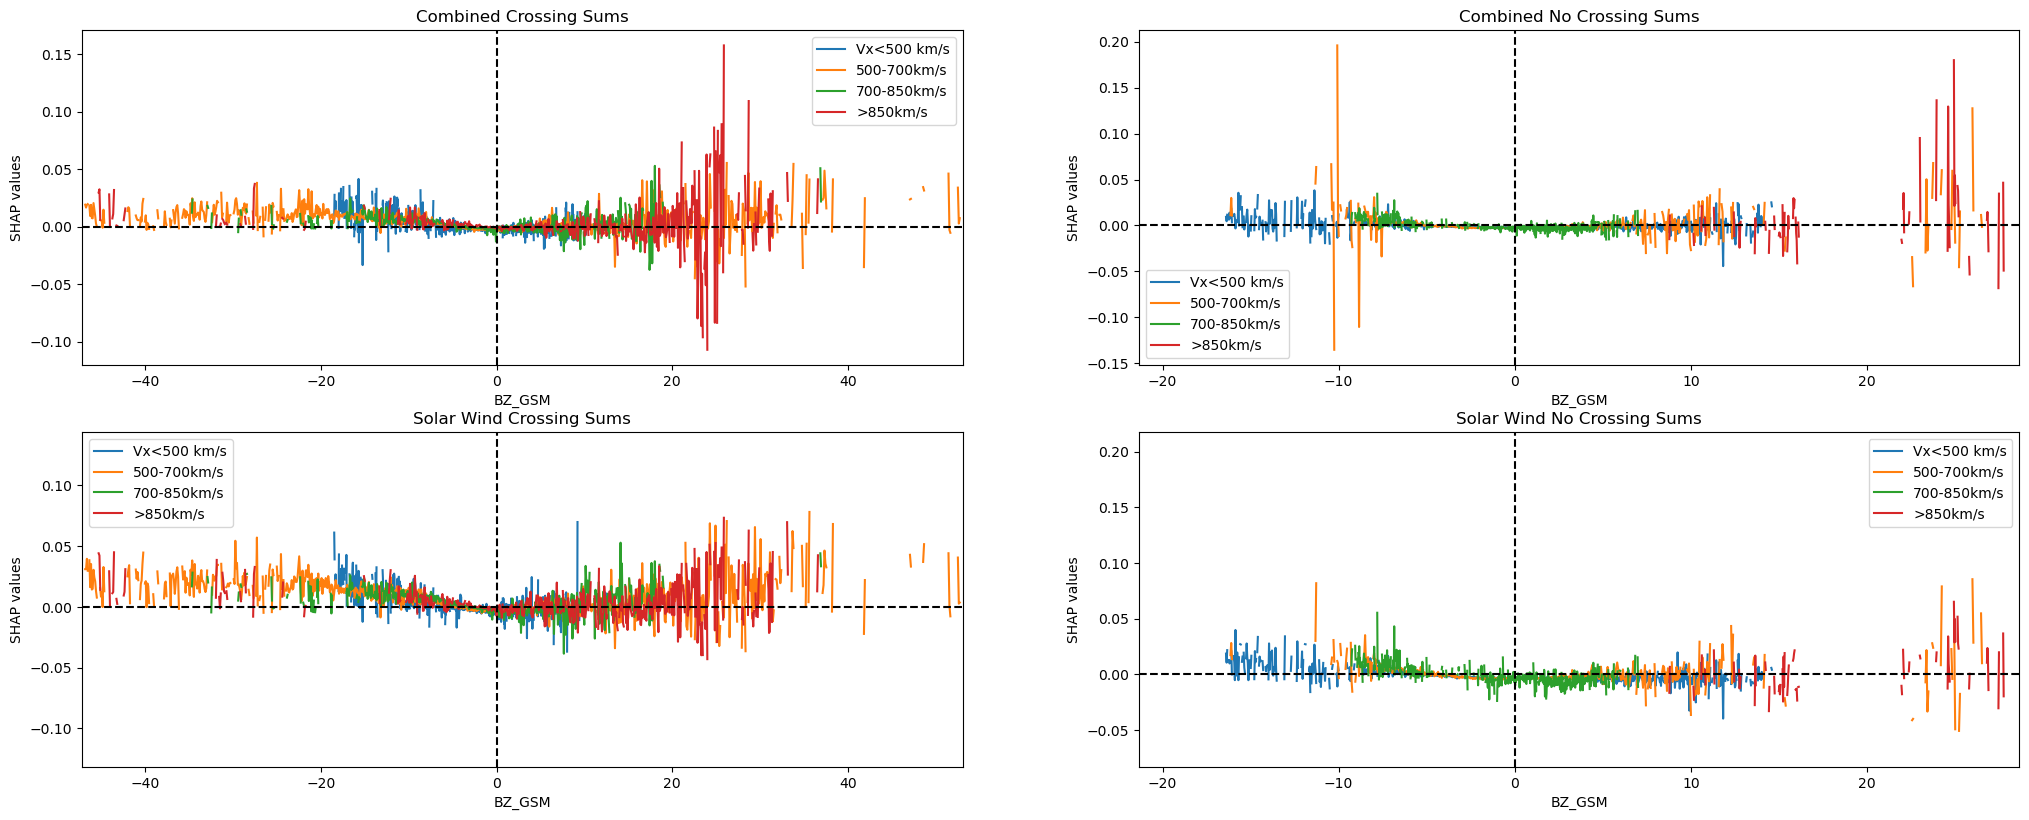

In [486]:
titles = ['Combined Crossing Sums', 'Combined No Crossing Sums', 'Solar Wind Crossing Sums', 'Solar Wind No Crossing Sums']
labels = ['Vx<500 km/s', '500-700km/s', '700-850km/s', '>850km/s']

fig = plt.figure(figsize=(25,20))
for i, (sums, title) in enumerate(zip(all_sums, titles)):
	ax = fig.add_subplot(4,2,i+1)
	plt.title(title)
	for s, label in zip(sums, labels):
		plt.plot(s.index, s['sums'], label=label)

	plt.axhline(0, color='black', linestyle='--')
	plt.axvline(0, color='black', linestyle='--')
	plt.xlabel(feat)
	plt.legend()
	plt.margins(x=0)
	plt.ylabel('SHAP values')

plt.show()
